# Main outline

In [1]:
# use stats from both teams that indicate their team strength in context of the match (so stats that include both team A and B)
# get average stats from last 5 games
# predict win/loss for a give game


## Imports

In [12]:
from nba_api.stats.endpoints import leaguegamefinder, BoxScoreAdvancedV2
import pandas as pd
import time
import warnings
import requests
import numpy as np
import os
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

nba_abbv_list = ["IND", "OKC", "NYK", "MIN", "DEN", "BOS", "GSW", "CLE", "HOU", "LAC",
    "DET", "LAL", "ORL", "MIL", "MIA", "MEM", "ATL", "DAL", "CHI", "SAC", "UTA", "NOP", "WAS", "TOR", "POR", "SAS", "CHA", "BKN", "PHX", "PHI"
]

## Functions

## Creating the Dataset
We get the necessary data from nba-api <br>
We first pull the whole season of data, and then we pull advanced box data based on each GAME_ID <br>
We also perform some simple data prep and memory saving by removing some of the columns we know we don't need to store (all of the estimated columns in the advanced box data) <br><br>
Save to CSV to be able to check things visually

In [96]:
"""completed: "IND", "OKC", "NYK", "MIN", "DEN", "BOS", "GSW", "CLE", "HOU", "LAC",
    "DET", "LAL", "ORL", "MIL", "MIA", "MEM", "ATL", "DAL", "CHI", "SAC", "UTA", "NOP", "WAS", "TOR", "POR", "SAS", "CHA", "BKN", "PHX", "PHI" """

nba_abbv_list = ["IND", "OKC", "NYK", "MIN", "DEN", "BOS", "GSW", "CLE", "HOU", "LAC",
    "DET", "LAL", "ORL", "MIL", "MIA", "MEM", "ATL", "DAL", "CHI", "SAC", "UTA", "NOP", "WAS", "TOR", "POR", "SAS", "CHA", "BKN", "PHX", "PHI"
]

In [9]:
# get list of teams and their abbreviations
season = '2024-25' 

# Create an instance of the LeagueGameFinder endpoint
gamefinder = leaguegamefinder.LeagueGameFinder(season_nullable=season, league_id_nullable='00')
games_df_2024_2025 = gamefinder.get_data_frames()[0]

# make sure GAME_DATE is date type
games_df_2024_2025['GAME_DATE'] = pd.to_datetime(games_df_2024_2025['GAME_DATE'])
# save TEAM_ID and TEAM_ABBREVIATION for mapping later on
team_id_abbv_map = games_df_2024_2025[['TEAM_ID', 'TEAM_ABBREVIATION','TEAM_NAME']].drop_duplicates()
# filtered to only the main 30 NBA teams
team_id_abbv_map.index = range(1, len(team_id_abbv_map) + 1)
team_id_abbv_map = team_id_abbv_map[team_id_abbv_map['TEAM_ABBREVIATION'].isin(nba_abbv_list)]



In [ ]:
# create data set with 2024 season
season = '2024-25' 

# Create an instance of the LeagueGameFinder endpoint
attempt = 0
max_retries = 5
retry_delay = 2
while attempt < max_retries:
    try:
        gamefinder = leaguegamefinder.LeagueGameFinder(season_nullable=season, league_id_nullable='00')
        break
    except (requests.exceptions.RequestException, requests.exceptions.ReadTimeout) as e:
        attempt += 1
        print(f"Attempt {attempt} failed: {e}")
        if attempt < max_retries:
            time.sleep(retry_delay)
    else:
        print(f"max retries reached, exiting on: {gid}")

games_df_2024_2025 = gamefinder.get_data_frames()[0]

# get last n Game IDs to use to get advanced box stats for given team
# team_abbv = 'LAL'
for abbv in nba_abbv_list:
    # !------------------ remove exit if you want to rerun, otherwise leave in case you accidentally execute cell ----------------------------!
    exit()
    print(abbv)
    cur_team_id = team_id_abbv_map.loc[team_id_abbv_map['TEAM_ABBREVIATION'] == abbv, 'TEAM_ID'].values[0]
    # print(cur_team_id)
    # filter on the given team
    cur_team_games_df_2024_2025 = games_df_2024_2025[games_df_2024_2025['TEAM_ABBREVIATION'] == abbv]

    # order by date
    cur_team_games_df_2024_2025 = cur_team_games_df_2024_2025.sort_values('GAME_DATE')

    # reindex
    cur_team_games_df_2024_2025 = cur_team_games_df_2024_2025.reset_index(drop=True)
    # add new columns
    new_cols = ['OFF_RATING', 'DEF_RATING', 'NET_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO',
    'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT',
    'USG_PCT', 'PACE', 'PACE_PER40', 'POSS', 'PIE']
    cur_team_games_df_2024_2025[new_cols] = pd.NA

    for i in range(len(cur_team_games_df_2024_2025)):
        # get game id
        gid = cur_team_games_df_2024_2025.iloc[i]['GAME_ID']
        # print(gid)
        attempt = 0
        max_retries = 7
        retry_delay = 2
        while attempt < max_retries:
            try:
                boxscore_adv = BoxScoreAdvancedV2(gid)
                break
            except (requests.exceptions.RequestException, requests.exceptions.ReadTimeout) as e:
                attempt += 1
                print(f"Attempt {attempt} failed: {e}")
                if attempt < max_retries:
                    time.sleep(retry_delay+attempt)
            else:
                print(f"max retries reached, exiting on: {gid}")

        team_stats_adv = boxscore_adv.get_data_frames()[1]
        just_cur_team_stats_adv = team_stats_adv[team_stats_adv['TEAM_ABBREVIATION'] == abbv]
        just_cur_team_stats_adv = just_cur_team_stats_adv.drop(['TEAM_CITY','TEAM_NAME'], axis=1)
        # remove all the columns that are estimates
        just_cur_team_stats_adv = just_cur_team_stats_adv.drop(columns=[col for col in just_cur_team_stats_adv.columns if col.startswith('E_')])
        # reindex 
        just_cur_team_stats_adv = just_cur_team_stats_adv.reset_index(drop=True)
        
        for c in new_cols:
            cur_team_games_df_2024_2025.at[i,c] = just_cur_team_stats_adv.at[0,c]
        
        # get box score advanced
    # cur_team_games_df_2024_2025
    # make GAME_ID a str
    # just_cur_team_stats_adv
    cur_team_games_df_2024_2025['GAME_ID'] = cur_team_games_df_2024_2025['GAME_ID'].astype(str).str.zfill(10)
    cur_team_games_df_2024_2025.to_csv(f"raw_data/{abbv}_raw.csv", index=False)
# boxscore_adv = BoxScoreAdvancedV2()
# team_stats_adv = boxscore_adv.get_data_frames()[1] #



## More data prep
Because of the save to CSV, we need to add back leading 0s for the GAME_ID in case future calls back to nba-api are needed. <br>
We save the new files as pickle files

In [ ]:
# add the leading zeroes for the GAME_ID

import os
folder_path = 'raw_data'

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        print(f"Processing file: {file_path}")
        n, ext = (os.path.splitext(filename))
        if ext.lower() == ".pkl":
            print("skipping pickle file")
            continue
        df = pd.read_csv(file_path)
        df['GAME_ID'] = df['GAME_ID'].astype(str).str.zfill(10)
        df.to_pickle(file_path.removesuffix('.csv')+'.pkl')

In [ ]:
# code to move files to new folder
from pathlib import Path
import shutil

# Set your initial folder path
initial_folder = Path('raw_data')

# Create new folders
csv_folder = initial_folder / 'csv'
pkl_folder = initial_folder / 'pkl'

csv_folder.mkdir(exist_ok=True)
pkl_folder.mkdir(exist_ok=True)

# Loop through files and move them
for file_path in initial_folder.iterdir():
    if file_path.is_file():
        if file_path.suffix == '.csv':
            shutil.move(str(file_path), str(csv_folder / file_path.name))
        elif file_path.suffix == '.pkl':
            shutil.move(str(file_path), str(pkl_folder / file_path.name))

print('Files moved successfully.')


## Creating aggregate using last n games
All of our predictors are going to be aggregated over the previous n games, obviously not including the current game. We want to get a picture of the team's strength going into that game

In [5]:
def create_rolling_avg_data_set(n_games, df):
    # add new column for days since last game
    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
    df['DAYS_SINCE_LAST_GAME'] = df.groupby('TEAM_ID')['GAME_DATE'].diff().dt.days

    # remove columns that won't be used
    df = df.drop(['SEASON_ID', 'TEAM_ID', 'TEAM_NAME', 'MIN', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'REB', 'PLUS_MINUS', 'NET_RATING', 'REB_PCT', 'EFG_PCT', 'TS_PCT','USG_PCT', 'PACE_PER40', 'PIE'], axis=1 )

    # change WL column to numeric (binary)
    df['WL'] = df['WL'].map({'W': 1, 'L': 0})

    # calulate rolling average after shift
    n_games = 3
    rolling_avg = df[['PTS', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA',
        'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
        'OFF_RATING', 'DEF_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO',
        'OREB_PCT', 'DREB_PCT', 'TM_TOV_PCT', 'PACE', 'POSS']].shift(1).rolling(window=n_games).mean()
    # rename columns
    rolling_avg.columns = [f"{col}_rolling_avg" for col in rolling_avg.columns]
    # join back with oiginal df
    df = pd.concat([df[['GAME_ID', 'GAME_DATE', 'TEAM_ABBREVIATION', 'WL', 'MATCHUP']],rolling_avg], axis=1)
    return df


In [6]:
# code to create the prepped data sets (which have the averages)
def prep_data_from_raw_n_games(raw_f, prep_f, n):
    # Loop through files and move them
    for file_name in os.listdir(raw_f):
        # print(file_name)
        # read in pkl file
        df = pd.read_pickle(raw_f + file_name)
        # make the new df
        new_df = create_rolling_avg_data_set(n, df)
        # remove rows with na
        new_df = new_df.dropna()
        new_path = prep_f + file_name.replace('raw', 'prepped')
        new_df.to_pickle(new_path) 



In [9]:
raw_f = 'raw_data/pkl/'
prep_f = 'prepped_data/'
n = 3 # the number of games you want to look back for

prep_data_from_raw_n_games(raw_f,prep_f, n)

## More Data Cleaning and Prep
We make the MATCHUP column just the opposing team's Abbreviation so that we can get their list of games and create columns for the opponent's stats

In [16]:
# clean up the matchups so that it only has the opposing team
# remove and rows where the matchup is not in the 30 NBA teams
# we can only do this removal step here because we had to calculate the days before last game column first

for file_name in os.listdir(prep_f):
    df = pd.read_pickle(prep_f + file_name)
    df['MATCHUP'] = df['MATCHUP'].str[-3:]
    df = df[df['MATCHUP'].isin(nba_abbv_list)]
    df.to_pickle(prep_f + file_name) 

In [15]:
# nba_abbv_list
for abbv in nba_abbv_list:
    # read in the df
    f_path = f"prepped_data\{abbv}_prepped.pkl"
    df1 = pd.read_pickle(f_path)
    # add the new columns
    for col in df1.columns:
        if not col.endswith('_o'):
            df1[f'{col}_o'] = np.nan
    df1 = df1.drop(columns=['GAME_ID_o', 'GAME_DATE_o', 'TEAM_ABBREVIATION_o', 'WL_o', 'MATCHUP_o'])

    cols2take = []
    cols2add = []
    for c in df1.columns:
        if c.endswith('_o'):
            cols2take.append(c[:-2])
            cols2add.append(c)
    # now cycle through the  matchups
    unique_opp_abbv_gid = list(df1[['MATCHUP', 'GAME_ID']].drop_duplicates().itertuples(index=False, name=None)) # gets the MATCHUP and GAME_ID pairs
    for opp_abbv, gid in unique_opp_abbv_gid:
        # read in the opposing team's df
        df2 = pd.read_pickle(f_path)
        # assign opposing team's stats to the _o columns we added to df1
        df1.loc[df1['GAME_ID'] == gid, cols2add] = df2.loc[df2['GAME_ID'] == gid, cols2take].values
    # write back to file
    df1.to_pickle(f_path) 


In [17]:
# add new opposing team columns based on stats
df1 = pd.read_pickle('prepped_data\SAC_prepped.pkl')
df2 = pd.read_pickle('prepped_data\SAS_prepped.pkl')

In [18]:
df2

,GAME_ID,GAME_DATE,TEAM_ABBREVIATION,WL,MATCHUP,PTS_rolling_avg,FGM_rolling_avg,FGA_rolling_avg,FG3M_rolling_avg,FG3A_rolling_avg,FTM_rolling_avg,FTA_rolling_avg,OREB_rolling_avg,DREB_rolling_avg,AST_rolling_avg,STL_rolling_avg,BLK_rolling_avg,TOV_rolling_avg,PF_rolling_avg,OFF_RATING_rolling_avg,DEF_RATING_rolling_avg,AST_PCT_rolling_avg,AST_TOV_rolling_avg,AST_RATIO_rolling_avg,OREB_PCT_rolling_avg,DREB_PCT_rolling_avg,TM_TOV_PCT_rolling_avg,PACE_rolling_avg,POSS_rolling_avg,PTS_rolling_avg_o,FGM_rolling_avg_o,FGA_rolling_avg_o,FG3M_rolling_avg_o,FG3A_rolling_avg_o,FTM_rolling_avg_o,FTA_rolling_avg_o,OREB_rolling_avg_o,DREB_rolling_avg_o,AST_rolling_avg_o,STL_rolling_avg_o,BLK_rolling_avg_o,TOV_rolling_avg_o,PF_rolling_avg_o,OFF_RATING_rolling_avg_o,DEF_RATING_rolling_avg_o,AST_PCT_rolling_avg_o,AST_TOV_rolling_avg_o,AST_RATIO_rolling_avg_o,OREB_PCT_rolling_avg_o,DREB_PCT_rolling_avg_o,TM_TOV_PCT_rolling_avg_o,PACE_rolling_avg_o,POSS_rolling_avg_o
3,0012400051,2024-10-15,SAS,0,MIA,113.333333,41.333333,87.666667,14.666667,40.666667,16.000000,23.666667,9.333333,32.333333,30.333333,11.333333,5.000000,15.666667,17.000000,108.833333,105.933333,0.735667,2.033333,20.966667,0.250333,0.739667,15.466667,103.666667,104.000000,113.333333,41.333333,87.666667,14.666667,40.666667,16.000000,23.666667,9.333333,32.333333,30.333333,11.333333,5.000000,15.666667,17.000000,108.833333,105.933333,0.735667,2.033333,20.966667,0.250333,0.739667,15.466667,103.666667,104.000000
4,0012400063,2024-10-17,SAS,0,HOU,116.666667,43.333333,86.333333,12.000000,36.333333,18.000000,26.666667,9.000000,35.333333,30.000000,11.000000,4.333333,15.666667,20.666667,111.000000,107.800000,0.693333,2.016667,20.766667,0.249333,0.783333,15.266667,104.500000,105.000000,116.666667,43.333333,86.333333,12.000000,36.333333,18.000000,26.666667,9.000000,35.333333,30.000000,11.000000,4.333333,15.666667,20.666667,111.000000,107.800000,0.693333,2.016667,20.766667,0.249333,0.783333,15.266667,104.500000,105.000000
5,0022400074,2024-10-24,SAS,0,DAL,116.666667,44.666667,89.333333,10.333333,33.000000,17.000000,23.666667,9.666667,33.000000,31.666667,9.000000,2.666667,15.000000,22.333333,110.666667,117.200000,0.710000,2.236667,21.533333,0.242667,0.725000,14.533333,105.166667,105.333333,116.666667,44.666667,89.333333,10.333333,33.000000,17.000000,23.666667,9.666667,33.000000,31.666667,9.000000,2.666667,15.000000,22.333333,110.666667,117.200000,0.710000,2.236667,21.533333,0.242667,0.725000,14.533333,105.166667,105.333333
6,0022400094,2024-10-26,SAS,1,HOU,111.000000,41.333333,86.666667,10.000000,33.333333,18.333333,24.666667,11.000000,35.666667,30.000000,6.666667,3.000000,17.333333,21.333333,106.366667,118.300000,0.728333,1.790000,20.633333,0.276667,0.700000,16.866667,104.166667,104.333333,111.000000,41.333333,86.666667,10.000000,33.333333,18.333333,24.666667,11.000000,35.666667,30.000000,6.666667,3.000000,17.333333,21.333333,106.366667,118.300000,0.728333,1.790000,20.633333,0.276667,0.700000,16.866667,104.166667,104.333333
7,0022400109,2024-10-28,SAS,0,HOU,108.333333,39.666667,86.666667,9.666667,30.000000,19.333333,24.333333,11.666667,34.666667,28.333333,6.333333,4.666667,16.000000,19.333333,107.400000,117.400000,0.713000,1.796667,19.833333,0.293000,0.647333,16.166667,100.833333,101.000000,108.333333,39.666667,86.666667,9.666667,30.000000,19.333333,24.333333,11.666667,34.666667,28.333333,6.333333,4.666667,16.000000,19.333333,107.400000,117.400000,0.713000,1.796667,19.833333,0.293000,0.647333,16.166667,100.833333,101.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,0022401139,2025-04-06,SAS,0,POR,110.333333,41.333333,90.666667,15.333333,42.000000,12.333333,16.333333,8.666667,36.000000,26.000000,7.333333,4.333333,12.666667,15.333333,110.033333,111.633333,0.629000,2.120000,18.966667,0.245333,0.731333,13.133333,100.500000,10

## Model Time!
Try XGBoost, logistic regression, neural network <br><br>
We are going to create a separate model for each team, and depending on the input we will choose the respective model (general model for all teams might not be good, but we can test that too after)

In [20]:
# for a team
df = pd.read_pickle('prepped_data\SAC_prepped.pkl')

# get train_test split (first 80, last 20)
train_size = int(len(df) * 0.8)

# columns we don't need: GAME_ID, GAME_DATE, TEAM_ABBREVIATION, MATCHUP
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]
X_train = train_df.drop(columns=['GAME_ID', 'GAME_DATE', 'TEAM_ABBREVIATION', 'MATCHUP', 'WL'])
X_test = test_df.drop(columns=['GAME_ID', 'GAME_DATE', 'TEAM_ABBREVIATION', 'MATCHUP', 'WL'])
y_train = train_df['WL']
y_test = test_df['WL']

In [21]:
# logistic reg as a start
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.5294117647058824


In [24]:
# XGBoost
import xgboost as xgb

model = xgb.XGBClassifier(
    objective='binary:logistic', 
    eval_metric='logloss', 
    use_label_encoder=False
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.4117647058823529


In [27]:
# random forest
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=20, random_state=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy (n = 20):", accuracy_score(y_test, y_pred))

model = RandomForestClassifier(n_estimators=50, random_state=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy (n = 50):", accuracy_score(y_test, y_pred))

model = RandomForestClassifier(n_estimators=100, random_state=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy (n = 100):", accuracy_score(y_test, y_pred))

Accuracy (n = 20): 0.4117647058823529
Accuracy (n = 50): 0.4117647058823529
Accuracy (n = 100): 0.47058823529411764


In [ ]:
# simple prediction with just BOS, use XGBoost (result: 0.58)
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score

# remove rows that have nulls
bos_2024_2025.dropna(inplace=True)

# set independent variables
X = bos_2024_2025[["PTS_rolling_avg", "FGM_rolling_avg", "FGA_rolling_avg", "FG3M_rolling_avg", "FG3A_rolling_avg", "FTM_rolling_avg", "FTA_rolling_avg", "OREB_rolling_avg", "DREB_rolling_avg", "AST_rolling_avg", "STL_rolling_avg", "BLK_rolling_avg", "TOV_rolling_avg", "PF_rolling_avg"
]]
y = bos_2024_2025["WL"]
# split into test and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
model = LinearRegression()
model = xgb.XGBClassifier(
    objective='binary:logistic', 
    eval_metric='logloss', 
    use_label_encoder=False
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')




Accuracy: 0.58


c:\Users\1997e\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:09:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


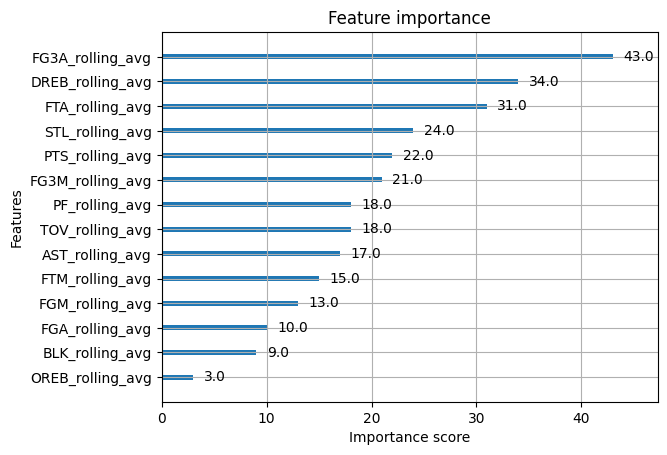

In [130]:
import matplotlib.pyplot as plt

xgb.plot_importance(model)
plt.show()

RuntimeError: `lowess=True` requires statsmodels, an optional dependency, to be installed.

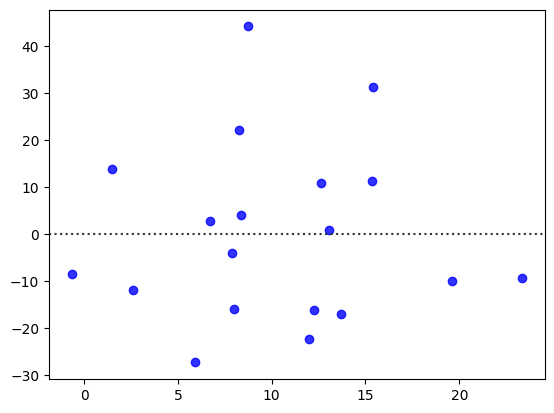

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

residuals = y_test - y_pred
sns.residplot(x=y_pred, y=residuals, lowess=True, color="BLUE")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

ValueError: x and y must be the same size

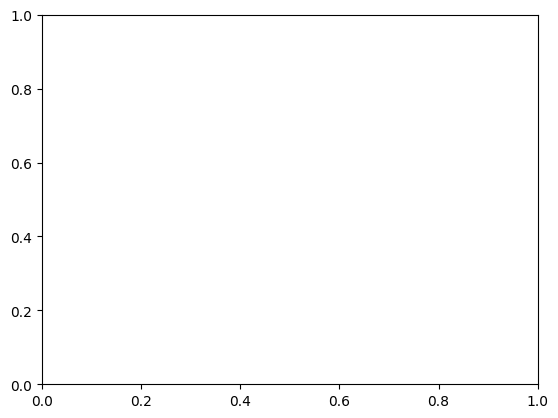

In [106]:
# visualize the model
import matplotlib.pyplot as plt
plt.scatter(X, y, color='blue', label='Actual')
plt.plot(X, y_pred, color='red', label='Regression line')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression')
plt.legend()
plt.show()


In [47]:
# test with BOS, Celtics
team_A_ID = 1610612738
team_a_game_ids = get_last_3_game_ids(team_A_ID)
print(team_a_game_ids)


['0042400214', '0042400215', '0042400216']


In [ ]:
for g_id in team_a_game_ids:
    print(g_id)
    print(combine_team_games(get_full_view(g_id)))
    # drop columns: 
    # SEASON_ID, TEAM_ABBREVIATION_A, TEAM_NAME_A, GAME_ID, PLUS_MINUS_B

0042400214
  SEASON_ID   TEAM_ID_A TEAM_ABBREVIATION_A      TEAM_NAME_A     GAME_ID  \
2     42024  1610612752                 NYK  New York Knicks  0042400214   

    GAME_DATE    MATCHUP_A WL_A  MIN_A  PTS_A  FGM_A  FGA_A  FG_PCT_A  FG3M_A  \
2  2025-05-12  NYK vs. BOS    W    240    121     50     92     0.543      12   

   FG3A_A  FG3_PCT_A  FTM_A  FTA_A  FT_PCT_A  OREB_A  DREB_A  REB_A  AST_A  \
2      34      0.353      9     12      0.75      13      30     43     25   

   STL_A  BLK_A  TOV_A  PF_A  PLUS_MINUS_A   TEAM_ID_B TEAM_ABBREVIATION_B  \
2      5      2     12    20           8.0  1610612738                 BOS   

      TEAM_NAME_B  MATCHUP_B WL_B  MIN_B  PTS_B  FGM_B  FGA_B  FG_PCT_B  \
2  Boston Celtics  BOS @ NYK    L    241    113     38     79     0.481   

   FG3M_B  FG3A_B  FG3_PCT_B  FTM_B  FTA_B  FT_PCT_B  OREB_B  DREB_B  REB_B  \
2      18      48      0.375     19     26     0.731       7      24     31   

   AST_B  STL_B  BLK_B  TOV_B  PF_B  PLUS_MINUS_B

In [11]:
celt_games.groupby(games.SEASON_ID.str[-4:])[['GAME_ID']].count().loc['2015':]

,GAME_ID
SEASON_ID,
2015,103
2016,115
2017,113
2018,101
2019,102
2020,80
2021,115
2022,111
2023,111


In [13]:
# filter games by year

celt_games2425 = celt_games[celt_games.SEASON_ID.str[-4:] == '2024']
celt_games2425.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,42024,1610612738,BOS,Boston Celtics,0042400216,2025-05-16,BOS @ NYK,L,241,81,...,0.700,9,27,36,19,4,3,15,22,-38.0
1,42024,1610612738,BOS,Boston Celtics,0042400215,2025-05-14,BOS vs. NYK,W,242,127,...,0.654,12,32,44,27,3,12,8,25,25.0
2,42024,1610612738,BOS,Boston Celtics,0042400214,2025-05-12,BOS @ NYK,L,241,113,...,0.731,7,24,31,15,8,2,12,16,-8.0
3,42024,1610612738,BOS,Boston Celtics,0042400213,2025-05-10,BOS @ NYK,W,242,115,...,0.882,12,30,42,23,6,8,8,26,22.0
4,42024,1610612738,BOS,Boston Celtics,0042400212,2025-05-07,BOS vs. NYK,L,240,90,...,0.800,16,35,51,17,9,5,16,17,-1.0


In [ ]:
# filter games by opponent
# Subset the games to where MATCHUP contains 'LAL'
LAL_celt_games2425 = celt_games2425[celt_games2425.MATCHUP.str.contains('LAL')]
LAL_celt_games2425.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
29,22024,1610612738,BOS,Boston Celtics,0022400918,2025-03-08,BOS vs. LAL,W,241,111,...,0.720,11,32,43,24,9,5,9,11,10.0
48,22024,1610612738,BOS,Boston Celtics,0022400629,2025-01-23,BOS @ LAL,L,239,96,...,0.667,11,31,42,23,5,6,7,17,-21.0
101,22024,1610612738,BOS,Boston Celtics,1522400029,2024-07-15,BOS @ LAL,W,200,88,...,0.750,14,24,38,21,6,9,15,17,14.0


: 

In [ ]:
# get all teams and their IDs
from nba_api.stats.static import teams

nba_teams = teams.get_teams()
nba_teams
my_l = []
for t in nba_teams:
    my_l.append(t['full_name'])
    my_l.append(t['id'])

my_l

['Atlanta Hawks',
 1610612737,
 'Boston Celtics',
 1610612738,
 'Cleveland Cavaliers',
 1610612739,
 'New Orleans Pelicans',
 1610612740,
 'Chicago Bulls',
 1610612741,
 'Dallas Mavericks',
 1610612742,
 'Denver Nuggets',
 1610612743,
 'Golden State Warriors',
 1610612744,
 'Houston Rockets',
 1610612745,
 'Los Angeles Clippers',
 1610612746,
 'Los Angeles Lakers',
 1610612747,
 'Miami Heat',
 1610612748,
 'Milwaukee Bucks',
 1610612749,
 'Minnesota Timberwolves',
 1610612750,
 'Brooklyn Nets',
 1610612751,
 'New York Knicks',
 1610612752,
 'Orlando Magic',
 1610612753,
 'Indiana Pacers',
 1610612754,
 'Philadelphia 76ers',
 1610612755,
 'Phoenix Suns',
 1610612756,
 'Portland Trail Blazers',
 1610612757,
 'Sacramento Kings',
 1610612758,
 'San Antonio Spurs',
 1610612759,
 'Oklahoma City Thunder',
 1610612760,
 'Toronto Raptors',
 1610612761,
 'Utah Jazz',
 1610612762,
 'Memphis Grizzlies',
 1610612763,
 'Washington Wizards',
 1610612764,
 'Detroit Pistons',
 1610612765,
 'Charlotte H

In [9]:
# team info
from nba_api.stats.endpoints import teaminfocommon
hornets_team = teaminfocommon.TeamInfoCommon('1610612766')
hornets_team.team_info_common.get_data_frame()


,TEAM_ID,SEASON_YEAR,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CONFERENCE,TEAM_DIVISION,TEAM_CODE,TEAM_SLUG,W,L,PCT,CONF_RANK,DIV_RANK,MIN_YEAR,MAX_YEAR
0,1610612766,2024-25,Charlotte,Hornets,CHA,East,Southeast,hornets,hornets,19,63,0.232,14,4,1988,2025


In [ ]:
# need to get game by game data


## Research

In [116]:
from nba_api.stats.endpoints import BoxScoreAdvancedV2

boxscore_adv = BoxScoreAdvancedV2()
team_stats_adv = boxscore_adv.get_data_frames()[1] #

# Look at columns like 'PACE' or 'POSS'
team_stats_adv
#print(team_stats_adv[['TEAM_ABBREVIATION', 'PACE', 'POSS']])

TypeError: BoxScoreAdvancedV2.__init__() missing 1 required positional argument: 'game_id'

In [115]:
player_stats_adv = boxscore_adv.get_data_frames()[1]
player_stats_adv

,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE
0,0042400216,1610612752,Knicks,NYK,New York,240.000000:00,119.9,125.3,83.2,86.2,36.7,39.1,0.595,1.79,18.0,0.420,0.793,0.62,14.107,14.7,0.549,0.594,1.0,0.198,98.32,94.5,78.75,95,0.735
1,0042400216,1610612738,Celtics,BOS,Boston,240.000000:00,83.2,86.2,119.9,125.3,-36.7,-39.1,0.613,1.19,15.2,0.207,0.580,0.38,16.427,17.0,0.430,0.448,1.0,0.195,98.32,94.5,78.75,94,0.265


In [82]:
import pandas as pd
import numpy as np

# First DataFrame
df1 = pd.DataFrame({
    'Points': np.random.randint(10, 30, size=5),
    'Rebounds': np.random.randint(5, 15, size=5),
    'Assists': np.random.randint(1, 10, size=5)
})

# Second DataFrame
df2 = pd.DataFrame({
    'Steals': np.random.randint(0, 5, size=5),
    'Blocks': np.random.randint(0, 5, size=5),
    'Turnovers': np.random.randint(1, 8, size=5)
})

print("DataFrame 1:\n", df1)
print("\nDataFrame 2:\n", df2)

DataFrame 1:
    Points  Rebounds  Assists
0      28         9        4
1      25        11        6
2      14        13        8
3      10        10        9
4      27         8        2

DataFrame 2:
    Steals  Blocks  Turnovers
0       3       1          1
1       0       4          7
2       0       0          5
3       2       3          4
4       2       4          7


In [83]:
df1[df2.columns] = pd.NA

In [85]:
df1.at[0,'Steals'] = df2.at[0,'Steals']
df1

,Points,Rebounds,Assists,Steals,Blocks,Turnovers
0,28,9,4,3,<NA>,<NA>
1,25,11,6,<NA>,<NA>,<NA>
2,14,13,8,<NA>,<NA>,<NA>
3,10,10,9,<NA>,<NA>,<NA>
4,27,8,2,<NA>,<NA>,<NA>
